<a href="https://colab.research.google.com/github/alexfc14/fancy-stats/blob/master/Combining_statistics_by_gender_for_equal_opportunity_hiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining statistics by gender for equal opportunity hiring

I was once asked by the HR department how to address the following statistical problem:

> *We have the answers from a candidate of a personality test, producing a score. We have some statistical information tables about the score distribution for each gender, but we are not allowed to ask it. How should we combine information from both genders to interpret the candidate score?*

Let us draw an example where we are told that both follow a normal distribution, where males score an average of -1 with standard deviation 2, and females score an average of 4 with standard deviation 2.

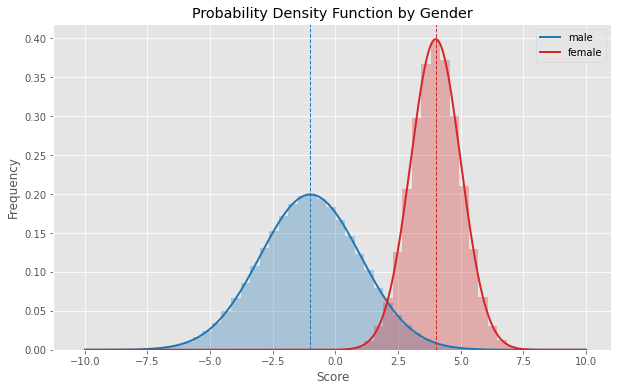

In [176]:
import scipy.stats as st
import pandas as pd
import numpy as np

#gender distribution descriptors
m1=-1;s1=2
m2=4;s2=1
D1=st.norm(m1, s1)
D2=st.norm(m2, s2)

#theoretical densities
x=pd.Series(np.arange(-9.99,10,0.01)).round(2)
pdf=pd.DataFrame(index=x)
pdf['male']=D1.pdf(x)
pdf['female']=D2.pdf(x)

#random samples
size=10**6
sample=pd.DataFrame()
sample['male']=D1.rvs(size)
sample['female']=D2.rvs(size)

#plot
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
matplotlib.style.use('ggplot')
colors=['tab:blue','tab:red','tab:purple']

ax=sample.plot(kind='hist',bins=50,density=True,alpha=.3,subplots=False,color=colors,legend=None)
ax=pdf.plot(ax=ax,color=colors,lw=2)
_=ax.axvline(x=m1, ls='--',c='tab:blue',lw=1)
_=ax.axvline(x=m2, ls='--',c='tab:red',lw=1)
_=ax.set_title('Probability Density Function by Gender')
_=ax.set_xlabel('Score')

**Short answer**: average the percentile of the score for both genders.

**Common mistake**: assuming each gender's score is normally distributed with known mean and variance, 
$X\sim N(\mu _m,\sigma _{m}^{2})$,
$Y\sim N(\mu _f,\sigma _{f}^{2})$, use the formula for average of normals, which is the normal with mean of means and quadratic mean of standard deviations, $Z = \frac{X + Y}{2} \sim N(\frac{\mu _{m}+\mu _{f}}{2}, \frac{\sigma _{m}^{2}+\sigma _{f}^{2} }{4})$.

Assuming a normal distribution for each gender is usually not incorrect. In fact, we are usually given only the sample mean and standard deviation as only descriptors. The mistake is to confuse a mixture of normals with an average of normals.

An **average** of normals would be valid if, for example, we make pairs of male and female candidates and average their score. The resulting distribution would be also normal, and inexperienced statisticians will mistakenly be compelled towards this desired property. Let us draw the average of normals, just for comparison.

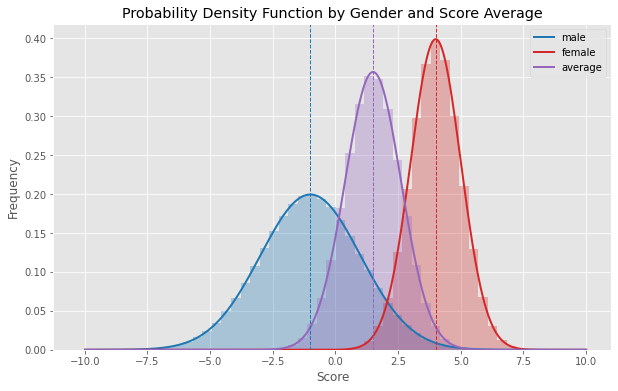

In [177]:
#theoretical density for average
m3=(m2+m1)/2; s3=((s1**2+s2**2)/4)**(1/2)
D3=st.norm(m3, s3)
pdf['average']=D3.pdf(x)

#random sample average
sample['average']=sample.mean(axis='columns')

#plot
ax=sample.plot(kind='hist',bins=50,density=True,alpha=.3,subplots=False,color=colors,legend=None)
ax=pdf.plot(ax=ax,color=colors,lw=2)
_=ax.axvline(x=m1, ls='--',c=colors[0],lw=1)
_=ax.axvline(x=m2, ls='--',c=colors[1],lw=1)
_=ax.axvline(x=m3, ls='--',c=colors[2],lw=1)
_=ax.set_title('Probability Density Function by Gender and Score Average')
_=ax.set_xlabel('Score')

Our case is different. We read a score from a candidate, which can be male with probability $p(\text{male})$ or female with probability $p(\text{female})=1-p(\text{male})$, ie, gender is a $\text{Bernouilli}(p(\text{male}))$. Unless prior knowledge is available, we will assume there are the same number of male as female candidates, so $p(\text{male})=p(\text{female})=\frac{1}{2}$. This phenomena is called **mixture** of normals, and we can model it via the density of probabilities:

The probability of a candidate having score $x$ can be obtained as a weighted sum of probabilities assuming each gender, the weights being the probability of belonging to each genders. This is just an application of the total probability formula:

$p(x)= p(\text{male}) p(x | \text{male}) + p(\text{female}) p(x | \text{female})$

Again, if $p(\text{male}=1/2)$, we have that the averaging happens not on the  variable, but on the probability space

$$p(x)= \frac{1}{2} p(x | \text{male}) + \frac{1}{2} p(x | \text{female})$$

$X|\text{male} \sim \mathcal N(\mu_m, \sigma^2_m )$

$X|\text{female} \sim \mathcal N(\mu_f, \sigma^2_f )$

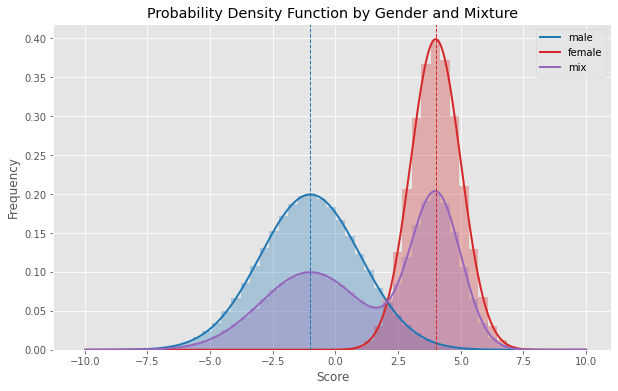

In [178]:
#discard the score average
pdf.drop('average',axis='columns',inplace=True)
sample.drop('average',axis='columns',inplace=True)

#theoretical density for mixture
pdf['mix']=pdf.mean(axis=1)

#random sample mixture
male = st.bernoulli(p=1/2).rvs(size)
sample['mix']=sample['male']*male + sample['female']*(1-male)

#plot
ax=sample.plot(kind='hist',bins=50,density=True,alpha=.3,subplots=False,color=colors,legend=None)
ax=pdf.plot(ax=ax,color=colors,lw=2)
_=ax.axvline(x=m1, ls='--',c=colors[0],lw=1)
_=ax.axvline(x=m2, ls='--',c=colors[1],lw=1)
_=ax.set_title('Probability Density Function by Gender and Mixture')
_=ax.set_xlabel('Score')

Note that this is not a normal distribution, it is bimodal.

Finally, a common way to position a score inside its distribution is the percentile, that is, out of 100 people, how does one's score rank: 0 is the minimum, 50 the median and 100 the maximum. The cumulative probability of a variable $X$ at a value $x$ is defined as the probability of $X$ having a value lower or equal than $x$, and it can be expressed as an integral of the point-wise density function below $x$
$$F_X(x)=P(X\leq x) = \int^x p(x) dx$$
, and it is well known and available for common distributions, including the normal. If we multiply it by 100 we obtain such ranking
$$\text{Percentile}(x)=100 F(x)$$

If we now decompose the point-wise density function for the mixture as an average of both male and female probabilities, since the integral of averages is the average of integrals,

$$F_X(x)
=P(X\leq x) = \int^x p(x) dx = \int^x \left( \frac{1}{2} p(x | \text{male}) + \frac{1}{2} p(x | \text{female}) \right) dx
\\=\frac{1}{2} \int^x p(x|\text{male}) dx + \frac{1}{2} \int^x p(x | \text{female}) dx
\\=\frac{1}{2} F_{\text{male}} (x) + \frac{1}{2} F_\text{female} (x)$$

So assuming we can compute the cumulative density function for each one, for example, calling the "cdf" method of the distribution, the percentile can be computed using just the average of both.

$$\text{Percentile}(x) = \frac{1}{2} \text{Percentile}_\text{male} (x) + \frac{1}{2} \text{Percentile}_\text{female} (x)$$

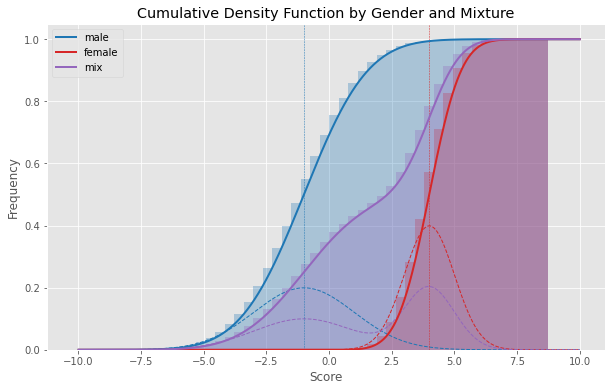

In [179]:
ax=pdf.plot(color=colors,style='--',legend=None,lw=1)
_=ax.axvline(x=m1, ls='--',c=colors[0],lw=.5)
_=ax.axvline(x=m2, ls='--',c=colors[1],lw=.5)

ax=sample.plot(kind='hist',cumulative=True,bins=50,density=True,alpha=.3,subplots=False,color=colors,legend=None,ax=ax)
pdf.cumsum().divide(100).plot(color=colors,lw=2,ax=ax)
_=ax.set_title('Cumulative Density Function by Gender and Mixture')
_=ax.set_xlabel('Score')

So, for example, a candidate scoring $x=2.5$, would rank $ 7\%$ if female and $ 96 \%$ if male, so he or she will rank $51 \%$ if gender is unknown.

We give a function for computing combined percentiles from two normal distributions with known parameters. Combining percentiles is valid for any distribution, including tabulated values.

In [180]:
import scipy.stats as st

def percentiles(x, m1, s1, m2, s2, ratio1=1/2, ratio2=1/2):
  percent1=st.norm(m1,s1).cdf(x)*100
  percent2=st.norm(m2,s2).cdf(x)*100
  percent_mix = (ratio1*percent1+ratio2*percent2)/(ratio1+ratio2)
  return {'percent1':percent1, 'percent2':percent2, 'percent_mix':percent_mix}

scores = pd.Series([-8,-5,-3,-2.5,-1,0,1,2.5,3,5,8])
pd.DataFrame.from_dict(scores.map(lambda x: percentiles(x, m1, s1, m2, s2)).to_dict()).T.set_index(scores).round(2)

,percent1,percent2,percent_mix
-8.0,0.02,0.00,0.01
-5.0,2.28,0.00,1.14
-3.0,15.87,0.00,7.93
-2.5,22.66,0.00,11.33
-1.0,50.00,0.00,25.00
0.0,69.15,0.00,34.57
1.0,84.13,0.13,42.13
2.5,95.99,6.68,51.34
3.0,97.72,15.87,56.80
5.0,99.87,84.13,92.00


If you are using excel, you can use
> =100*NORM.DIST(x, mean, standard_dev, TRUE)

for the percentile of value $x$ in each normal distribution, and then take the average of both.